### Import required packages and dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
nltk.download('all')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     C:\Users\manas\AppData\Roaming\nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     C:\Users\manas\AppData\Roaming\nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     C:\Users\manas\AppData\Roaming\nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     C:\Users\manas\AppData\Roaming\nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_eng is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     C:\Users\manas\AppData\Roaming\nltk_data...
[

In [2]:
data = pd.read_excel("Sentiment Analysis.xlsx")
data.head()

,title,rating,body
0,Horrible product,1,Very disappointed with the overall performance...
1,Camera quality is not like 48 megapixel,3,Camera quality is low
2,Overall,4,"Got the mobile on the launch date,Battery must..."
3,A big no from me,1,1. It doesn't work with 5.0GHz WiFi frequency....
4,Put your money somewhere else,1,"Not worth buying....faulty software, poor disp..."


### Exploration

In [3]:
print("Data Information:")
display(data.info())

Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1440 entries, 0 to 1439
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   1440 non-null   object
 1   rating  1440 non-null   int64 
 2   body    1440 non-null   object
dtypes: int64(1), object(2)
memory usage: 33.9+ KB


None

In [4]:
if(data.duplicated().sum() > 0):
    print("There are duplicate rows in the dataset.")
    display(data[data.duplicated()])
else:
    print("No duplicate rows found in the dataset.")

No duplicate rows found in the dataset.


In [5]:
print("\nMissing Values in Each Column:")
display(data.isnull().sum())


Missing Values in Each Column:


title     0
rating    0
body      0
dtype: int64

In [6]:
print("\nStatistical Summary of Numerical Columns:")
display(data.describe())


Statistical Summary of Numerical Columns:


,rating
count,1440.000000
mean,3.173611
std,1.584453
min,1.000000
25%,1.000000
50%,4.000000
75%,5.000000
max,5.000000


### Rating distribution

C:\Users\manas\AppData\Local\Temp\ipykernel_16004\2939639708.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='rating', data=data, palette='viridis')


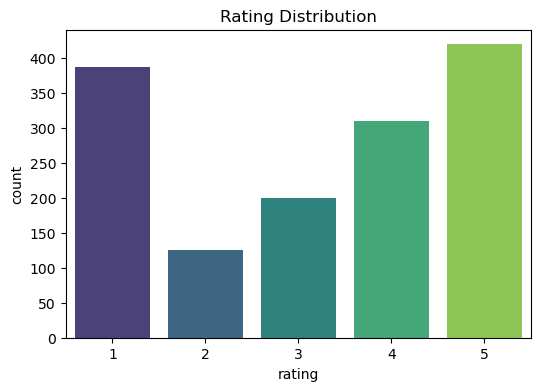

In [7]:
plt.figure(figsize=(6,4))
sns.countplot(x='rating', data=data, palette='viridis')
plt.title("Rating Distribution")
plt.show()

### Combine title and body into one text column

In [8]:
data['text'] = data['title'].astype(str) + " " + data['body'].astype(str)
data.drop(['title', 'body'], axis=1, inplace=True)
data.head()

,rating,text
0,1,Horrible product Very disappointed with the ov...
1,3,Camera quality is not like 48 megapixel Camera...
2,4,"Overall Got the mobile on the launch date,Batt..."
3,1,A big no from me 1. It doesn't work with 5.0GH...
4,1,Put your money somewhere else Not worth buying...


### Language detect

In [9]:
from langdetect import detect

data['language'] = data['text'].apply(lambda x: detect(x))
print(data['language'].value_counts())

language
en    1412
hi      11
id       5
ca       4
af       2
lv       1
ml       1
et       1
de       1
so       1
no       1
Name: count, dtype: int64


### Translate unknown language

In [10]:
from deep_translator import GoogleTranslator

# Function to translate only if not English
def translate_text(text, lang):
    try:
        if lang != 'en':  # translate only non-English reviews
            return GoogleTranslator(source='auto', target='en').translate(text)
        else:
            return text
    except:
        return text  # if translation fails, keep original

# Apply translation only where needed
data['text'] = data.apply(lambda x: translate_text(x['text'], x['language']), axis=1)

### Text cleaning function (normalization + punctuation removal)

In [11]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('[‘’“”…]', '', text)
    return text

data['clean_text'] = data['text'].apply(clean_text)
data.head()

,rating,text,language,clean_text
0,1,Horrible product Very disappointed with the ov...,en,horrible product very disappointed with the ov...
1,3,Camera quality is not like 48 megapixel Camera...,ca,camera quality is not like megapixel camera qu...
2,4,"Overall Got the mobile on the launch date,Batt...",en,overall got the mobile on the launch datebatte...
3,1,A big no from me 1. It doesn't work with 5.0GH...,en,a big no from me it doesnt work with ghz wifi ...
4,1,Put your money somewhere else Not worth buying...,en,put your money somewhere else not worth buying...


### Tokenization

In [12]:
data['tokens'] = data['clean_text'].apply(word_tokenize)
data.head()

,rating,text,language,clean_text,tokens
0,1,Horrible product Very disappointed with the ov...,en,horrible product very disappointed with the ov...,"[horrible, product, very, disappointed, with, ..."
1,3,Camera quality is not like 48 megapixel Camera...,ca,camera quality is not like megapixel camera qu...,"[camera, quality, is, not, like, megapixel, ca..."
2,4,"Overall Got the mobile on the launch date,Batt...",en,overall got the mobile on the launch datebatte...,"[overall, got, the, mobile, on, the, launch, d..."
3,1,A big no from me 1. It doesn't work with 5.0GH...,en,a big no from me it doesnt work with ghz wifi ...,"[a, big, no, from, me, it, doesnt, work, with,..."
4,1,Put your money somewhere else Not worth buying...,en,put your money somewhere else not worth buying...,"[put, your, money, somewhere, else, not, worth..."


### custom stop words

In [13]:
custom_stopwords = set([
    'aa','yr''phoneand', 'phonegood', 'phonei', 'phoneit', 'phonemain', 'phoneno', 'phoneoverall', 'phonepay', 'phonephone',
    'phonescreen', 'phonethe', 'phonevery', 'phonevery slow', 'phonedont', 'ph', 'phn', 'phon',
    'pre', 'pre installed', 'preinstalled', 'preloaded', 'okbattery', 'oke', 'okok', 'school',
    'paid', 'review', 'tube', 'dont', 'go', 'by', 'many', 'may', 'might', 'according', 'pls','plz',
    'using', 'purchased', 'purchasing', 'received', 'buy', 'bought', 'would', 'even', 'really', 'phone',
    'mobile', 'product', 'device', 'screen', 'battery', 'camera','price', 'review', 'received', 'purchased',
    'buy', 'got', 'one', 'is', 'this', 'it', 'in', 'for', 'on', 'with', 'of', 'from'
])


In [14]:
important_words = [
    'not', 'no', 'never', 'bad', 'good', 'best', 'worst', 'awful', 'terrible', 'amazing',
    'poor', 'great', 'excellent', 'happy', 'disappointed', 'unhappy', 'satisfied', 'unsatisfied',
    'recommend', 'value', 'money', 'waste', 'problem', 'issue', 'fast', 'slow', 'smooth', 'trust',
    'comfortable', 'cheap', 'expensive', 'perfect', 'camera', 'battery', 'screen', 'display',
    'sound', 'touch', 'storage', 'processor', 'ram', 'performance', 'pubg', 'gaming', 'play', 'game',
    'easy', 'difficult', 'simple', 'complicated', 'yes', 'hate', 'loved', 'liked', 'hated'
]

### Stopword removal

In [15]:
stop_words = set(stopwords.words('english'))
stop_words = stop_words - set(important_words)
all_stopwords = stop_words.union(custom_stopwords)
data['tokens'] = data['tokens'].apply(lambda x: [word for word in x if word not in all_stopwords])
data.head()

,rating,text,language,clean_text,tokens
0,1,Horrible product Very disappointed with the ov...,en,horrible product very disappointed with the ov...,"[horrible, disappointed, overall, performance,..."
1,3,Camera quality is not like 48 megapixel Camera...,ca,camera quality is not like megapixel camera qu...,"[quality, not, like, megapixel, quality, low]"
2,4,"Overall Got the mobile on the launch date,Batt...",en,overall got the mobile on the launch datebatte...,"[overall, launch, datebattery, must, appreciat..."
3,1,A big no from me 1. It doesn't work with 5.0GH...,en,a big no from me it doesnt work with ghz wifi ...,"[big, no, doesnt, work, ghz, wifi, frequency, ..."
4,1,Put your money somewhere else Not worth buying...,en,put your money somewhere else not worth buying...,"[put, money, somewhere, else, not, worth, buyi..."


### Lemmatization

In [16]:
lemmatizer = WordNetLemmatizer()
data['lemmatized'] = data['tokens'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
data.head()

,rating,text,language,clean_text,tokens,lemmatized
0,1,Horrible product Very disappointed with the ov...,en,horrible product very disappointed with the ov...,"[horrible, disappointed, overall, performance,...","[horrible, disappointed, overall, performance,..."
1,3,Camera quality is not like 48 megapixel Camera...,ca,camera quality is not like megapixel camera qu...,"[quality, not, like, megapixel, quality, low]","[quality, not, like, megapixel, quality, low]"
2,4,"Overall Got the mobile on the launch date,Batt...",en,overall got the mobile on the launch datebatte...,"[overall, launch, datebattery, must, appreciat...","[overall, launch, datebattery, must, appreciat..."
3,1,A big no from me 1. It doesn't work with 5.0GH...,en,a big no from me it doesnt work with ghz wifi ...,"[big, no, doesnt, work, ghz, wifi, frequency, ...","[big, no, doesnt, work, ghz, wifi, frequency, ..."
4,1,Put your money somewhere else Not worth buying...,en,put your money somewhere else not worth buying...,"[put, money, somewhere, else, not, worth, buyi...","[put, money, somewhere, else, not, worth, buyi..."


### Final Text column

In [17]:
data['final_text'] = data['lemmatized'].apply(lambda x: ' '.join(x))
data.head()


,rating,text,language,clean_text,tokens,lemmatized,final_text
0,1,Horrible product Very disappointed with the ov...,en,horrible product very disappointed with the ov...,"[horrible, disappointed, overall, performance,...","[horrible, disappointed, overall, performance,...",horrible disappointed overall performance samsung
1,3,Camera quality is not like 48 megapixel Camera...,ca,camera quality is not like megapixel camera qu...,"[quality, not, like, megapixel, quality, low]","[quality, not, like, megapixel, quality, low]",quality not like megapixel quality low
2,4,"Overall Got the mobile on the launch date,Batt...",en,overall got the mobile on the launch datebatte...,"[overall, launch, datebattery, must, appreciat...","[overall, launch, datebattery, must, appreciat...",overall launch datebattery must appreciatedcam...
3,1,A big no from me 1. It doesn't work with 5.0GH...,en,a big no from me it doesnt work with ghz wifi ...,"[big, no, doesnt, work, ghz, wifi, frequency, ...","[big, no, doesnt, work, ghz, wifi, frequency, ...",big no doesnt work ghz wifi frequency ghz old ...
4,1,Put your money somewhere else Not worth buying...,en,put your money somewhere else not worth buying...,"[put, money, somewhere, else, not, worth, buyi...","[put, money, somewhere, else, not, worth, buyi...",put money somewhere else not worth buyingfault...


### Text Length Analysis

Text Length Descriptive Statistics:


count    1440.000000
mean      195.318750
std       140.219278
min         4.000000
25%       115.000000
50%       162.500000
75%       231.250000
max      1653.000000
Name: text_length, dtype: float64

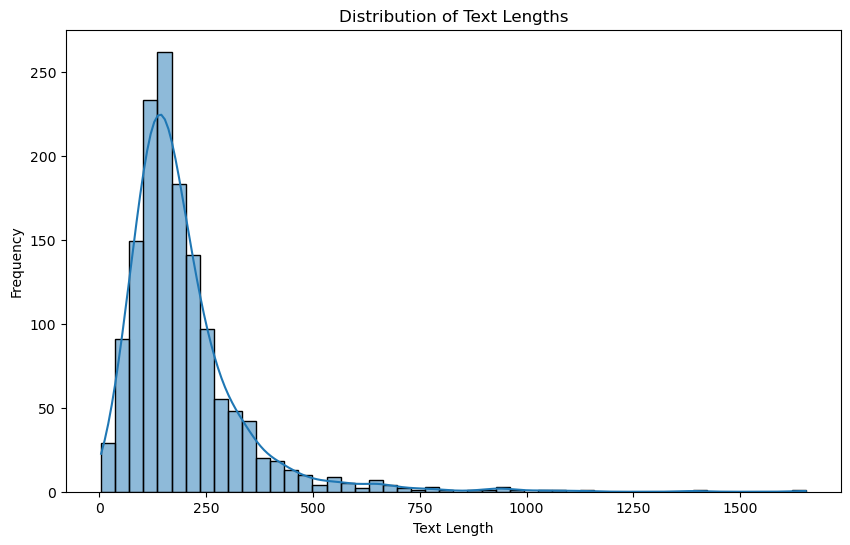

In [18]:
data['text_length'] = data['final_text'].apply(len)

print("Text Length Descriptive Statistics:")
display(data['text_length'].describe())

plt.figure(figsize=(10, 6))
sns.histplot(data['text_length'], bins=50, kde=True)
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

### Word frequency visualization

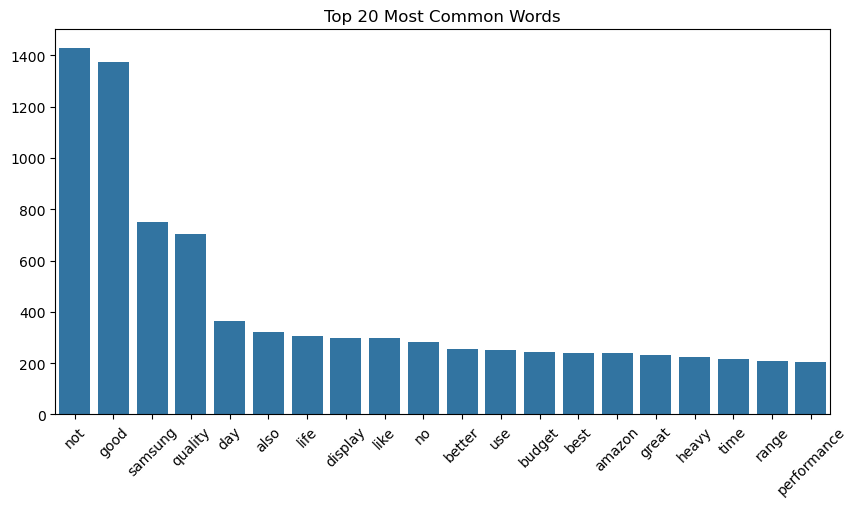

In [19]:
from collections import Counter
all_words = [word for tokens in data['lemmatized'] for word in tokens]
freq_dist = Counter(all_words)
common_words = freq_dist.most_common(20)

words, counts = zip(*common_words)
plt.figure(figsize=(10,5))
sns.barplot(x=list(words), y=list(counts))
plt.title("Top 20 Most Common Words")
plt.xticks(rotation=45)
plt.show()


In [20]:
text = " ".join(data["final_text"])


### Final cleaned dataset

In [21]:
data.drop(['language', 'text', 'tokens', 'lemmatized', 'text_length'], axis=1, inplace=True)
display(data.head())
data.shape

,rating,clean_text,final_text
0,1,horrible product very disappointed with the ov...,horrible disappointed overall performance samsung
1,3,camera quality is not like megapixel camera qu...,quality not like megapixel quality low
2,4,overall got the mobile on the launch datebatte...,overall launch datebattery must appreciatedcam...
3,1,a big no from me it doesnt work with ghz wifi ...,big no doesnt work ghz wifi frequency ghz old ...
4,1,put your money somewhere else not worth buying...,put money somewhere else not worth buyingfault...


(1440, 3)

###  Generate wordcloud

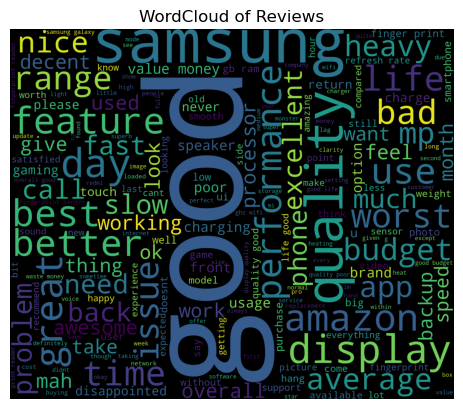

In [22]:
from wordcloud import WordCloud
wordcloud_stw = WordCloud(
                background_color= 'black',
                width = 1800,
                height = 1500,
                ).generate(text)
plt.axis('off')
plt.title("WordCloud of Reviews")
plt.imshow(wordcloud_stw)

### Sentiment Labels

In [23]:
# Create Y variable: text-based sentiment (using TextBlob analysis)
from textblob import TextBlob

def get_text_sentiment(text):
    polarity = TextBlob(str(text)).sentiment.polarity
    if polarity > 0.1:
        return 'positive'
    elif polarity <= -0.1:
        return 'negative'
    else:
        return 'neutral'
    
def get_polarity(text):
    return TextBlob(str(text)).sentiment.polarity

data['text_sentiment'] = data['clean_text'].apply(get_text_sentiment)
data['text_polarity'] = data['clean_text'].apply(get_polarity)
data

,rating,clean_text,final_text,text_sentiment,text_polarity
0,1,horrible product very disappointed with the ov...,horrible disappointed overall performance samsung,negative,-0.658333
1,3,camera quality is not like megapixel camera qu...,quality not like megapixel quality low,neutral,0.000000
2,4,overall got the mobile on the launch datebatte...,overall launch datebattery must appreciatedcam...,neutral,0.022222
3,1,a big no from me it doesnt work with ghz wifi ...,big no doesnt work ghz wifi frequency ghz old ...,neutral,-0.004805
4,1,put your money somewhere else not worth buying...,put money somewhere else not worth buyingfault...,neutral,0.029762
...,...,...,...,...,...
1435,5,excellent mobile excellent mobile,excellent excellent,positive,1.000000
1436,1,never expected from samsung all over mobile pe...,never expected samsung performance poor never ...,negative,-0.438000
1437,5,good value for money battery life is good but ...,good value money life good clarity could littl...,positive,0.409167
1438,1,unreal and whitish display its a very bad prod...,unreal whitish display bad highly dissatisfied...,negative,-0.305556


### Initialize tf-idf vectorizer



In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=8000)

### Transform the Text Data



In [25]:
tfidf_vectorizer.fit(data['final_text'])
print("TF-IDF vectorizer fitted successfully.")

tfidf_matrix = tfidf_vectorizer.transform(data['final_text'])

print("Text data transformed into TF-IDF matrix.")
print("TF-IDF matrix shape:", tfidf_matrix.shape)

TF-IDF vectorizer fitted successfully.
Text data transformed into TF-IDF matrix.
TF-IDF matrix shape: (1440, 8000)


### Convert TF-IDF Matrix to DataFrame



In [26]:
# Convert the TF-IDF matrix to a DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

print("TF-IDF matrix converted to DataFrame.")
print("TF-IDF DataFrame shape:", tfidf_df.shape)
print("\nTF-IDF DataFrame (first 5 rows):")
display(tfidf_df)

TF-IDF matrix converted to DataFrame.
TF-IDF DataFrame shape: (1440, 8000)

TF-IDF DataFrame (first 5 rows):


,aap hi,aaya,aaya tha,ab,ab jab,abhi,abhi class,abide,abide indian,ability,...,zoom selfi,zoom super,zoom team,zoomgoogle,zoomgoogle meet,zoomheavybattery,zoomheavybattery good,zooming,zooming image,zooming photo
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1436,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1437,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1438,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Train Test split

In [27]:
X = tfidf_df
y = data['text_sentiment']

In [28]:
#Train-Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### Confusion Matrix

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def ConfusionMatrix(y_test, y_pred, model):
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap='Greens')
    plt.title("Confusion Matrix - Sentiment Analysis")
    plt.show()


### Grid Search(Fine Tuning)

In [30]:
from sklearn.model_selection import GridSearchCV

def train_and_tune_model(estimator, param_grid, X_train, X_test, y_train, y_test, cv=5, scoring='accuracy'):
    grid = GridSearchCV(estimator, param_grid, cv=cv, scoring=scoring, n_jobs=-1)
    grid.fit(X_train, y_train)
    print("Best params:", grid.best_params_)
    print("Best cross-val score:", grid.best_score_)
    print("Test score:", grid.score(X_test, y_test))
    return grid


### Linear SVM

Linear SVM Accuracy: 0.7777777777777778

Classification Report:
               precision    recall  f1-score   support

    negative       0.78      0.71      0.74        55
     neutral       0.55      0.35      0.43        60
    positive       0.82      0.95      0.88       173

    accuracy                           0.78       288
   macro avg       0.72      0.67      0.68       288
weighted avg       0.76      0.78      0.76       288



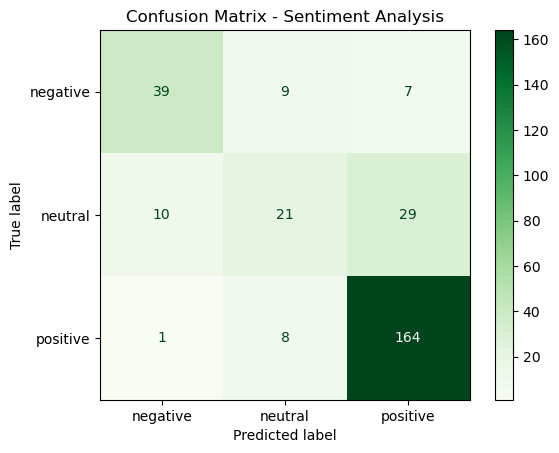

None


In [31]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report

svm_model = LinearSVC(random_state=42)
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

print("Linear SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print("\nClassification Report:\n", classification_report(y_test, y_pred_svm))
print(ConfusionMatrix(y_test, y_pred_svm, svm_model))


In [32]:
import joblib

# After training your LinearSVC model and TF-IDF vectorizer:
joblib.dump(svm_model, 'linearSVC_model.joblib')
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.joblib')

['tfidf_vectorizer.joblib']